In [65]:
import argparse
import sys
import time

import numpy as np
import tensorflow as tf

def load_graph(model_file):
    graph = tf.Graph()
    graph_def = tf.GraphDef()
    with open(model_file, "rb") as f:
        graph_def.ParseFromString(f.read())
    with graph.as_default():
        tf.import_graph_def(graph_def)
    return graph

def read_tensor_from_image_file(file_name, input_height=299, input_width=299,input_mean=0, input_std=255):
    input_name  = "file_reader"
    output_name = "normalized"
    
    file_reader = tf.read_file(file_name, input_name)
    if file_name.endswith(".png"):
        image_reader = tf.image.decode_png(file_reader, channels = 3,name='png_reader')
        
    elif file_name.endswith(".gif"):
        image_reader = tf.squeeze(tf.image.decode_gif(file_reader,name='gif_reader'))
        
    elif file_name.endswith(".bmp"):
        image_reader = tf.image.decode_bmp(file_reader, name='bmp_reader')
        
    else:
        image_reader = tf.image.decode_jpeg(file_reader, channels = 3,name='jpeg_reader')
        
    float_caster  = tf.cast(image_reader, tf.float32)
    dims_expander = tf.expand_dims(float_caster, 0)
    resized       = tf.image.resize_bilinear(dims_expander, [input_height, input_width])
    normalized    = tf.divide(tf.subtract(resized, [input_mean]), [input_std])
    
    sess          = tf.Session()
    result        = sess.run(normalized)

    return result

def load_labels(label_file):
    label = []
    proto_as_ascii_lines = tf.gfile.GFile(label_file).readlines()
    for l in proto_as_ascii_lines:
        label.append(l.rstrip())
    return label

In [66]:
def predict(file_name,labels_key):
    if not file_name:
        file_name   = "datasets/1000/1.jpg"
        
    model_file  = "graph/retrained_graph.pb"
    label_file  = "graph/retrained_labels.txt"
    
    input_height= 224
    input_width = 224
    input_mean  = 128
    input_std   = 128
    input_layer = "input"
    output_layer= "final_result"

    graph = load_graph(model_file)
    t = read_tensor_from_image_file(file_name,input_height=input_height,input_width=input_width,\
                                    input_mean=input_mean,input_std=input_std)
    
    input_name  = "import/" + input_layer
    output_name = "import/" + output_layer

    input_operation  = graph.get_operation_by_name(input_name);
    output_operation = graph.get_operation_by_name(output_name);

    with tf.Session(graph=graph) as sess:
        start   = time.time()
        results = sess.run(output_operation.outputs[0],{input_operation.outputs[0]: t})

    end     = time.time()
    results = np.squeeze(results)

    top_k  = results.argsort()[-5:][::-1]
    labels = load_labels(label_file)

    #print('\nEvaluation time (1-image): {:.3f}s\n'.format(end-start))
    template = "{} (score={:0.5f})"
    
#     for i in top_k:
#         print(template.format(labels[i], results[i]))
    return labels_key[labels[top_k[0]]]

In [73]:
from sklearn.metrics import confusion_matrix
import itertools
import matplotlib.pyplot as plt

def plot_confusion_matrix(cm, classes,normalize=False,title='Confusion matrix',cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),horizontalalignment="center",color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [68]:
import os

In [69]:
class_names = ['500','1000','2000','5000','10000']
labels_key = {'500':0,'1000':1,'2000':2,'5000':3,'10000':4}
y_pred = []
y_test = []

for c in range(len(class_names)):
    print("Working on ==============",class_names[c])
    images_list  = os.listdir('datasets/'+class_names[c])
    for image in images_list:
        result = predict('datasets/'+class_names[c]+'/'+image,labels_key)
        y_pred.append(result)
        y_test.append(labels_key[class_names[c]])

Working on ============== 500
Working on ============== 1000
Working on ============== 2000
Working on ============== 5000
Working on ============== 10000


Confusion matrix, without normalization
[[487   4   5   4   0]
 [  4 494   1   1   0]
 [  2   1 488   0   9]
 [  1   6   0 493   0]
 [  2   0   3   0 495]]
Normalized confusion matrix
[[0.97 0.01 0.01 0.01 0.  ]
 [0.01 0.99 0.   0.   0.  ]
 [0.   0.   0.98 0.   0.02]
 [0.   0.01 0.   0.99 0.  ]
 [0.   0.   0.01 0.   0.99]]


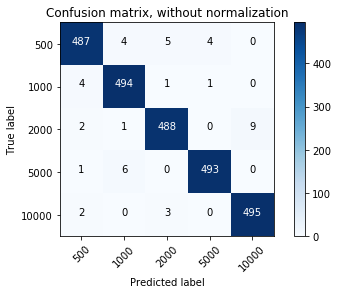

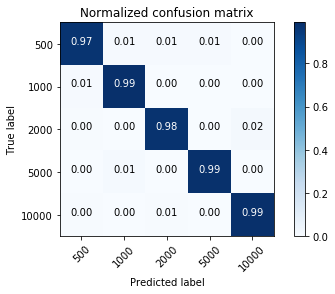

In [74]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,title='Normalized confusion matrix')

plt.show()